In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from simulations import sim_randomised, sim_constrained, sim_automated
import random
import matplotlib.pyplot as plt
from torch.distributions import Categorical

#GNN related imports
import torch_geometric.nn as geom_nn

from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import Data
from torch_geometric.data import Batch

import torch.optim as optim


import math


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
class ActorCritic(nn.Module):
    def __init__(self, gnn_output_dim, n_actions, hidden_dim=32):
        super(ActorCritic, self).__init__()
        
        self.n_actions = n_actions
        
        self.actor = nn.Sequential(
            nn.Linear(gnn_output_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, n_actions),
        )
        self.critic = nn.Sequential(
            nn.Linear(gnn_output_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, graph_feature_vector,action_mask,temperature=1.0):
        logits = self.actor(graph_feature_vector) / temperature
        #print(logits, "direct logits")
        logits += action_mask
        #print(logits)
        
        action_probs = F.softmax(logits, dim=-1)
        state_value = self.critic(graph_feature_vector)
        return action_probs, state_value

I choosed GraphConv as I want a general-purpose graph convolution that can be configured in various ways.
Might use MessagePassing in need to implement a custom GNN layer that involves a novel form of message passing between nodes.

In [4]:
class StateGNN(nn.Module):
    def __init__(self, node_feature_dim, output_dim, num_layers=4, hidden_dim=32):
        super(StateGNN, self).__init__()
        # Define GNN layers
        
        #self.conv1 = geom_nn.GraphConv(node_feature_dim, 256)
        #self.conv2 = geom_nn.GraphConv(256, 128)
        #self.conv3 = geom_nn.GraphConv(128, 64)
        # An output layer that produces the feature vector for the actor model
        
        self.num_layers = num_layers
        if num_layers == 1:
            self.conv = geom_nn.GraphConv(node_feature_dim, output_dim)
        else:
            # Multi-layer model
            self.convs = torch.nn.ModuleList()
        
            self.convs.append(geom_nn.GraphConv(node_feature_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.convs.append(geom_nn.GraphConv(hidden_dim, hidden_dim))
            self.convs.append(geom_nn.GraphConv(hidden_dim, output_dim))


        

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GNN layers
        #x = F.relu(self.conv1(x, edge_index))
        #x = F.relu(self.conv2(x, edge_index))
        #x = F.relu(self.conv3(x, edge_index))
        
        for layer in range(self.num_layers):
            x = F.relu(self.convs[layer](x,edge_index))
        
        # Global pooling to create a graph-level feature vector
        x = geom_nn.global_mean_pool(x, data.batch)

        # Output layer
        return x

In [5]:
class PPO:
    def __init__(self, 
                 node_feature_dim,
                 gnn_output_dim, 
                 n_actions,
                 lr_actor,
                 lr_critic,
                 lr_graph,
                 gamma,
                 K_epochs,
                 eps_clip,
                 gae_lambda):
        
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.gae_lambda = gae_lambda

        self.gnn_processor = StateGNN(node_feature_dim, gnn_output_dim)
        self.policy = ActorCritic(gnn_output_dim, n_actions)
        self.optimizer = optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic},
            {'params': self.gnn_processor.parameters(), 'lr': lr_graph}
        ])
        
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9998)

        self.policy_old = ActorCritic(gnn_output_dim, n_actions)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def select_action(self, state_data, memory,action_mask, temperature=1.0):
        
        # Not sure if I need it
        #state = torch.FloatTensor(state.reshape(1, -1))
        
        gnn_output = self.gnn_processor(state_data)
        
        with torch.no_grad():
            masked_action_probs, _ = self.policy_old(gnn_output, action_mask, temperature)
        
        dist = Categorical(masked_action_probs)
        action = dist.sample()
        
        
        memory.states.append(state_data)
        memory.actions.append(action)
        memory.masks.append(torch.tensor(action_mask))
        memory.logprobs.append(dist.log_prob(action))

        return action

    def update(self, memory):
        gae, targets = self.calculate_gae_and_targets(memory)


        old_states = Batch.from_data_list(memory.states)
        old_actions = torch.squeeze(torch.stack(memory.actions)).detach()
        old_masks = torch.squeeze(torch.stack(memory.masks)).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs)).detach()
        losses = []
        
        # Normalizing the rewards
        gae = torch.tensor(gae)
        gae = (gae - gae.mean()) / (gae.std() + 1e-7)

        for _ in range(self.K_epochs):
            # Evaluate old actions and values
            gnn_outputs = self.gnn_processor(old_states)
            logprobs, state_values = self.policy(gnn_outputs,old_masks)
            state_values = torch.squeeze(state_values)
            dist_entropy = -torch.sum(logprobs * torch.exp(logprobs), dim=1)
            new_logprobs = logprobs.gather(1, old_actions.view(-1, 1)).squeeze()
            
            # Find the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(new_logprobs - old_logprobs)
            
            # Calculate surrogate losses
            surr1 = ratios * gae
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * gae
            
            # Final loss
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, targets) - 0.01*dist_entropy
            
            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
            losses.append(loss.mean().detach().cpu().numpy())
        
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        return losses
        
    def calculate_gae_and_targets(self, memory):
        gae = 0
        targets = []
        gae_values = []
        values = memory.values + [0]
    
        for i in reversed(range(len(memory.rewards))):
            delta = memory.rewards[i] + self.gamma * values[i+1] * (1 - memory.is_terminals[i]) - values[i]
            gae = delta + self.gamma * self.gae_lambda * gae * (1 - memory.is_terminals[i])
            gae_values.insert(0, gae)
            targets.insert(0, gae + values[i])

        gae_values = torch.tensor(gae_values, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)

        return gae_values, targets


In [6]:
class Memory:
    def __init__(self):
        self.actions = []
        self.masks = []
        self.states = []
        self.rewards = []
        self.is_terminals = []
        self.logprobs = []
        self.values = []


    def clear_memory(self):
        del self.actions[:]
        del self.masks[:]
        del self.states[:]
        del self.rewards[:]
        del self.is_terminals[:]
        del self.logprobs[:]
        del self.values[:]


In [7]:
def show(losses, success_rates):
    figure, axis = plt.subplots(2, 1,figsize=(20, 15) )

    x = range(len(losses))
    a, b = np.polyfit(x,losses , 1)

    axis[0].plot(x, losses)

    x = range(len(success_rates))
    # Creating the plot

    a, b = np.polyfit(x,success_rates , 1)

    axis[1].scatter(x, success_rates)

    axis[1].plot(x, a*x+b,color='red',linewidth=4.5)

    plt.show()   

18


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_25551/28972780.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gae = torch.tensor(gae)


episode  25  is done!


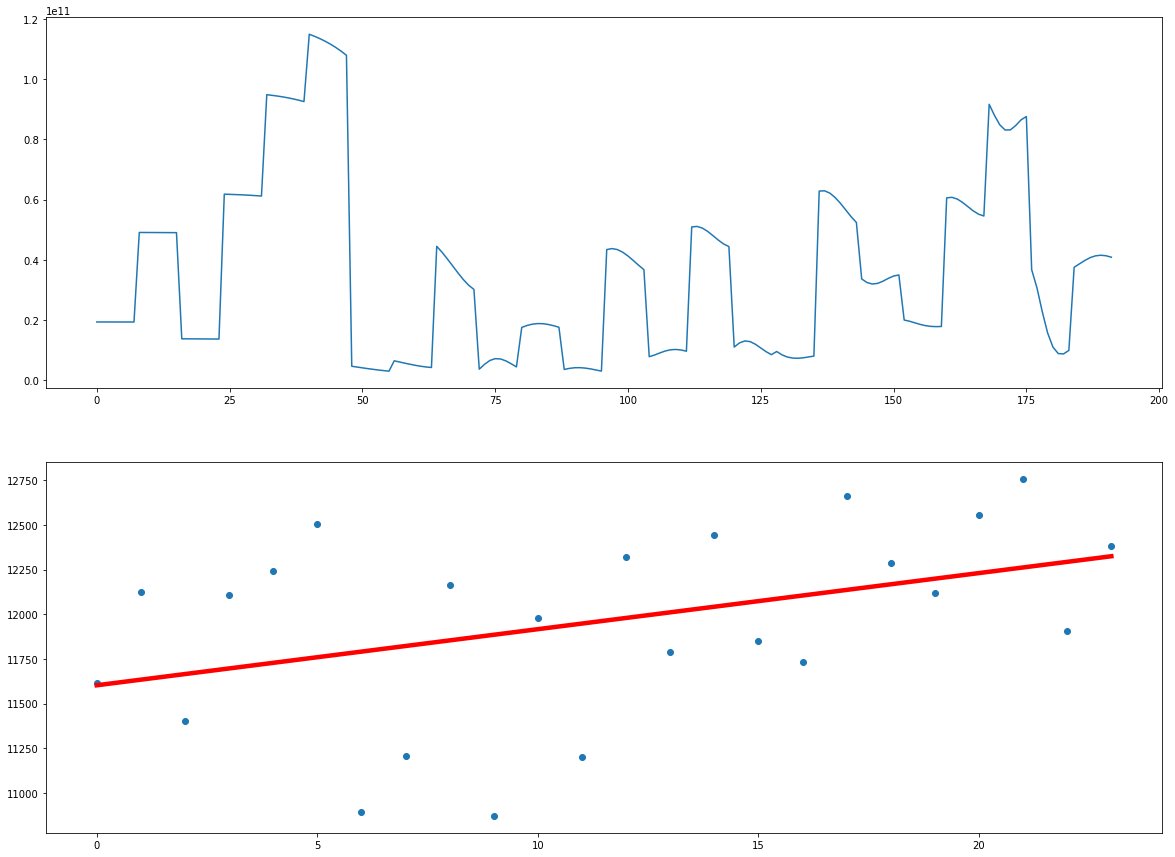

1.908
Epoch 25: Current Learning Rate: [4e-10, 0.002, 0.0002]


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_25551/28972780.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gae = torch.tensor(gae)


episode  50  is done!


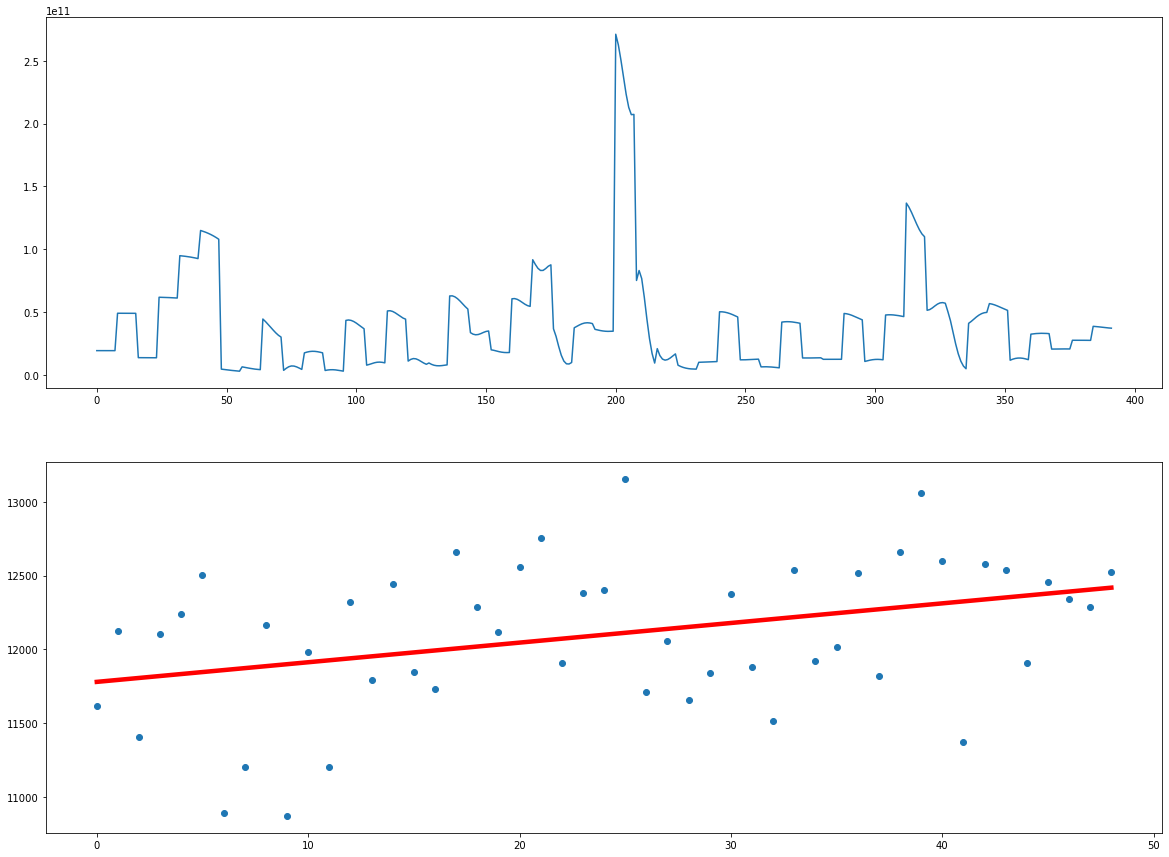

1.808
Epoch 50: Current Learning Rate: [4e-10, 0.002, 0.0002]


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_25551/28972780.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gae = torch.tensor(gae)


KeyboardInterrupt: 

In [10]:
# Initialize your environment and the PPO agent
env = sim_constrained.Env(visualise=False, verbose=False, model=True,goal="min_time", graph = True)
node_feature_dim = env.node_feature_dim
gnn_output_dim = 32 # Proposed gnn output 

print(node_feature_dim)

n_states = env.n_states
n_actions = env.n_actions

ppo_agent = PPO(node_feature_dim, gnn_output_dim, n_actions, lr_actor=4e-10, lr_critic=2e-3, lr_graph=2e-4, gamma=0.97, K_epochs=8, eps_clip=0.08, gae_lambda=0.97)
memory = Memory()

initial_temperature = 2  # Starting temperature
final_temperature = 1    # Minimum temperature
decay_rate = 0.002          # Rate of temperature decay
current_temperature = initial_temperature

# Training loop
num_episodes = 8000
success_rates = []
losses = []

for episode in range(num_episodes):
    if not (episode + 1) % 25:
        print("episode ", episode+1, " is done!")
        show(losses, success_rates)
        print(current_temperature)
        # Optional: print the current learning rate
        current_lr = ppo_agent.scheduler.get_last_lr()  # get_last_lr returns a list for each param group
        print(f"Epoch {episode+1}: Current Learning Rate: {current_lr}")
    
    current_temperature = max(final_temperature, initial_temperature * (1 - decay_rate * episode))


    _, state_data, action_mask = env.reset()


    #print(current_temperature)
        
    done = False

    while not done:
        action = ppo_agent.select_action(state_data, memory, action_mask)
        #print(action)
        state_data, reward, done, action_mask, success_rate = env.step(action)
        
        #print(state_data, reward, done, success_rate )
        
        if done:
            #reward += math.exp(success_rate / 10 )
            reward -= 2 * math.exp(success_rate/1000 )

        # Save in memory
        memory.rewards.append(reward)
        memory.is_terminals.append(done)
        state_temp = ppo_agent.gnn_processor(state_data)
        with torch.no_grad():
            _, state_value = ppo_agent.policy_old(torch.FloatTensor(state_temp).unsqueeze(0), action_mask)
            memory.values.append(state_value)
        
        
        
    
    success_rates.append(success_rate)
    #print(success_rate)
    
    # Update PPO agent
    losses += ppo_agent.update(memory)
    
    #ppo_agent.scheduler.step()
    
    memory.clear_memory()

    # Log results, etc.


In [ ]:
print(min(success_rates))

101 220


In [114]:
test_env = sim_constrained.Env(visualise=True, verbose=False, model=True, test=True, goal="min_time",graph = True)
_, state_data, action_mask = env.reset()

done = False

while not done:
    action = ppo_agent.select_action(state_data, memory, action_mask)
    #print(action)
    state_data, reward, done, action_mask, success_rate = test_env.step(action)
    #print(state, reward, done, action_mask, success_rate )


All products are produced at time:  102
From total  8  order,  6  was before their due dates. Success rate is:  75.0 %


In [42]:
#torch.save(ppo_agent, '/Users/hazarckr/Documents/Semester_3/idp/schedulingGNN/trainedModel2.pth')

Freezed Values:
    
self.actor = nn.Sequential(
            nn.Linear(n_states, 512),
            
            nn.PReLU(),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            
            nn.Linear(64, n_actions),
        )
        self.critic = nn.Sequential(
            nn.Linear(n_states, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
    
    
ppo_agent = PPO(n_states, n_actions, lr_actor=0.00007, lr_critic=0.003, gamma=0.98, K_epochs=10, eps_clip=0.08, gae_lambda=0.97)
memory = Memory()

initial_temperature = 3  # Starting temperature
final_temperature = 1    # Minimum temperature
decay_rate = 0.001          # Rate of temperature decay
current_temperature = initial_temperature